# Figure 1 - Study overview and genome-wide allele frequency changes

In [1]:
# load external dependencies
import matplotlib.pyplot as plt
%matplotlib inline
# import reconstruction_tools as rt
import glob, os, re
import numpy as np
import pandas as pd # (*) Pandas for data manipulation

import json, matplotlib
s = json.load( open("matplotlibrc.json") )
matplotlib.rcParams.update(s)

# load internal dependencies
import sys
sys.path.append('/Users/ivg/software/pytools/') # the pytools dir contains the package
from pytools import seq,pheno,utils

# relative file path for data directory
dir_data = "/Users/ivg/projects/yeast-cancer-drugs/paper/science/submission/data/"
dir_paper = "/Users/ivg/projects/yeast-cancer-drugs/paper/science/submission/manuscript/main/"
dir_supp = "/Users/ivg/projects/yeast-cancer-drugs/paper/science/submission/manuscript/supp/"

/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/ivg/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
sgd_length = pd.read_csv('~/reference/SGD_2010.lengths', names=['chr_arabic','chrs','chr_length'], index_col=False, sep=' ')
sgd_length = sgd_length[~(sgd_length['chr_arabic'].isin([17,18]))]
sgd_length['chr_start'] = ((pd.rolling_sum((sgd_length['chr_length']), 2) - sgd_length['chr_length']).fillna(0)).cumsum(axis=0)
sgd_length['chr_end'] = (sgd_length['chr_length'] + 1).cumsum(axis=0)
sgd_length = sgd_length.drop('chr_length', axis=1)

In [3]:
# files = glob.glob(data+"SNVs.seg.*.filtered.posterior-?.txt")
jfiles = glob.glob(dir_data+"seq/filterHD-v1.0/seg_sites/pools/SNVs.seg.WAxNA_F12_1_HU_1.filtered.jumps.txt")

jumps_df = pd.DataFrame()
for jj in jfiles:
    # read into pandas dataframe
    frame = pd.read_csv(jj, sep=' ', index_col=None)
    frame.rename(columns={'#sample': 'chr'}, inplace=True)
    #
    f = re.split(r'[.-]+', os.path.basename(jj))
    frame['sample'] = f[2]
    frame['time'] = f[5]
    #
    jumps_df = jumps_df.append(frame, ignore_index=True)
jumps_df.head()

pfiles = glob.glob(dir_data+"seq/filterHD-v1.0/seg_sites/pools/SNVs.seg.WAxNA_F12_1_*_1.filtered.posterior-*.txt")

post_df = pd.DataFrame()
for pp in pfiles:
    # read into pandas dataframe
    frame = pd.read_csv(pp, sep=r"\s+", index_col=None)
    frame.rename(columns={'#sample': 'chr_arabic'}, inplace=True)
    #
    f = re.split(r'[.-]+', os.path.basename(pp))
    frame['sample'] = f[2]
    frame['background'] = f[2].split('_')[0]
    frame['cross'] = f[2].split('_')[1]
    frame['cross_rep'] = f[2].split('_')[2]
    frame['env'] = f[2].split('_')[3]
    frame['prop_rep'] = f[2].split('_')[4]
    frame['time'] = int(f[5])
    #
    post_df = post_df.append(frame, ignore_index=True)
    
post_df = post_df.merge(sgd_length, how='left', on='chr_arabic')
post_df['pos'] = post_df.chr_start + post_df.site

post_df['chr_roman'] = post_df['chr_arabic'].apply(utils.int2roman)

post_df = post_df[post_df.env!='MO']

post_df = pd.pivot_table(post_df, index=['sample','chr_roman','pos'], columns=['time'], values='mean')

post_df.head()

time                                2      4      8      16     32
sample           chr_roman pos                                    
WAxNA_F12_1_HU_1 I         2718  0.920  0.931  0.929  0.956  0.978
                           2731  0.920  0.931  0.930  0.957  0.979
                           2734  0.920  0.931  0.930  0.957  0.979
                           4532  0.932  0.948  0.944  0.969  0.985
                           5035  0.924  0.951  0.949  0.960  0.986

In [4]:
def set_custom_labels(index, pos):
    """
    
    """
    start = dict((m[pos], ii) for ii,m in enumerate(index.values))
    end = dict((m[pos], len(index)-ii-1) for ii,m in enumerate(index[::-1].values))
    labels = {key: (start[key] + end.get(key, 0))/2. + 0.5 for key in end.keys()}
    
    return start, end, labels

In [5]:
def lineplot(X, ax, title, xlabel, ylabel, xticklabels, yticklabels, cmap='RdBu', vmin=0.0, vmax=1.0, show=False):
    '''

    '''
    
    # Plot it out
#     c = ax.pcolor(X, linewidths=0, cmap=cmap, vmin=vmin, vmax=vmax)
    X.plot(ax=ax, lw=0.5, legend=False)

    # Place the major ticks at the middle of each cell
#     ax.set_xticks(np.arange(X.shape[1]) + 0.5, minor=False)
#     ax.set_yticks(np.arange(X.shape[0]) + 0.5, minor=False)

    # set tick labels
#     ax.set_xticklabels(xticklabels, minor=False, rotation=90)
#     ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Remove last blank column
#     ax.set_xlim( (0, X.shape[1]) )
#     ax.set_ylim( (0, X.shape[0]) )

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

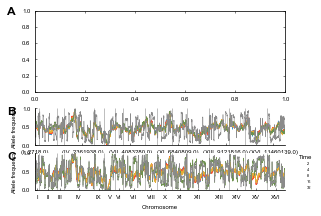

In [6]:
from matplotlib.ticker import MaxNLocator

fig = plt.figure(figsize=(4, 3), dpi=300)

import matplotlib.gridspec as gridspec
grid = gridspec.GridSpec(2, 1, height_ratios=[1,1])#, hspace=0.4, wspace=0.4)

gs = {}
gs['schematic'] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[0])
gs['freq'] = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=grid[1])

# fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(4.6, 5), sharex=True, sharey=True)

### top panel ###
ax1 = plt.subplot(gs['schematic'][:])

# img = SVG(url='http://upload.wikimedia.org/wikipedia/en/a/a4/Flag_of_the_United_States.svg')

# ax.imshow(img)

ax1.text(-0.075, 1.05,  chr(ord('A')), transform=ax1.transAxes,
         fontsize=12, fontweight='bold', va='top', ha='right')

### bottom panels ###
groups = post_df.groupby(level='sample', sort=False)

for ii, (k, g) in enumerate(groups):

    ax2 = plt.subplot(gs['freq'][ii])
    
    title = ''
    xlabel= ''
    ylabel= ''
    xticklabels = []
    yticklabels = []

    lineplot(g.ix[k], ax2, title, xlabel, ylabel, xticklabels, yticklabels, cmap='Purples')

    utils.simple_axes(ax2)
    
    ax2.text(-0.075, 1.05,  chr(ii + ord('B')), transform=ax2.transAxes,
             fontsize=12, fontweight='bold', va='top', ha='right')
    
    ax2.set_ylim((0, 1))
    ax2.yaxis.set_major_locator(MaxNLocator(nbins=2))
    
    xstart, xend, xlabels = set_custom_labels(g.index, 1)
    # labels
    if ax2.is_last_row():
        ax2.set_xticks(xlabels.values(), minor=False)
        ax2.set_xticklabels(xlabels.keys(), minor=False)
    # grid
    xgrid=[xst+1. for xst in list(set(xstart.values()))]
    [ax2.axvline(x, lw=0.5, ls="-", color="gray") for x in xgrid]
    
    ax2.set_ylabel('Allele frequency')
    
ax2.set_xlabel('Chromosome')

leg = ax2.legend(bbox_to_anchor=(1.05, 0.5), frameon=False, prop={'size':4},
                 loc='center left', borderaxespad=0.,
                 handlelength=0.75, title='Time')

plt.setp(leg.get_title(),fontsize=6)

# axes limits
for ax in fig.get_axes():
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    ax.tick_params(axis='both', which='major', size=2, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=1, labelsize=4)
    for sp in ax.spines.values():
        sp.set(color='k', linewidth=0.75, linestyle='-')
    
fig.savefig(dir_paper+'figures/figure1/figure1.png', dpi=300, bbox_inches='tight')
fig.savefig(dir_paper+'figures/figure1/figure1.svg', dpi=300, bbox_inches='tight')
plt.show()